<a href="https://colab.research.google.com/github/OMONa-E/Cirrhosis-Status-Prediction/blob/main/Cirrhosis_Prediction_NueralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Omona Emmanuel

**Context**

Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism. The following data contains the information collected from the Mayo Clinic trial in primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984. A description of the clinical background for the trial and the covariates recorded here is in Chapter 0, especially Section 0.2 of Fleming and Harrington, Counting
Processes and Survival Analysis, Wiley, 1991. A more extended discussion can be found in Dickson, et al., Hepatology 10:1-7 (1989) and in Markus, et al., N Eng J of Med 320:1709-13 (1989).

A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo-controlled trial of the drug D-penicillamine. The first 312 cases in the dataset participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.

**Attribute Information**

1) ID: unique identifier

2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986

3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)

4) Drug: type of drug D-penicillamine or placebo
5) Age: age in [days]

6) Sex: M (male) or F (female)

7) Ascites: presence of ascites N (No) or Y (Yes)

8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)

9) Spiders: presence of spiders N (No) or Y (Yes)

10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)

11) Bilirubin: serum bilirubin in [mg/dl]

12) Cholesterol: serum cholesterol in [mg/dl]

13) Albumin: albumin in [gm/dl]

14) Copper: urine copper in [ug/day]

15) Alk_Phos: alkaline phosphatase in [U/liter]

16) SGOT: SGOT in [U/ml]

17) Triglycerides: triglicerides in [mg/dl]

18) Platelets: platelets per cubic [ml/1000]

19) Prothrombin: prothrombin time in seconds [s]

20) Stage: histologic stage of disease (1, 2, 3, or 4)

**Acknowledgements**

The dataset can be found in appendix D of:

Fleming, T.R. and Harrington, D.P. (1991) Counting Processes and Survival Analysis. Wiley Series in Probability and Mathematical Statistics: Applied Probability and Statistics, John Wiley and Sons Inc., New York.

fedesoriano. (August 2021). Cirrhosis Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/cirrhosis-prediction-dataset.

In [21]:
!pip install -q -U keras-tuner

In [22]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import seaborn as sns
# set display to 100 maximum columns
pd.set_option('display.max_columns',100)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, LabelBinarizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.metrics import silhouette_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.io as pio
from sklearn.feature_selection import f_classif, f_regression, VarianceThreshold, SelectFromModel, SequentialFeatureSelector
from sklearn.cluster import KMeans
# Deep learning tools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperParameters as hp
import keras_tuner as kt
from keras_tuner import HyperModel

In [23]:
# define file path of our dataset
fpath = '/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week17/Data/cirrhosis.csv'
# read and load dataset with pandas
cir_df = pd.read_csv(fpath)

###### Explore/Clean data

In [24]:
# obtain the .info and head of the dataframe
display(cir_df.info(),cir_df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

None

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0


In [25]:
# set ID to index of the dataframe
cir_df.set_index('ID', inplace=True)

# for the 7 object type features we check for consistancy
for item in cir_df.select_dtypes('object').columns:
  print(f'{cir_df[item].value_counts(dropna=False)}')
  print('\n')

Status
C     232
D     161
CL     25
Name: count, dtype: int64


Drug
D-penicillamine    158
Placebo            154
NaN                106
Name: count, dtype: int64


Sex
F    374
M     44
Name: count, dtype: int64


Ascites
N      288
NaN    106
Y       24
Name: count, dtype: int64


Hepatomegaly
Y      160
N      152
NaN    106
Name: count, dtype: int64


Spiders
N      222
NaN    106
Y       90
Name: count, dtype: int64


Edema
N    354
S     44
Y     20
Name: count, dtype: int64




In [26]:
# check for duplicates
cir_df.duplicated().sum()

0

#### NueralNetwork MODEL

In [27]:
# @title Evaluate FUNC
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



In [28]:
# @title History Plot Func
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [29]:
# @title Train Test split
### possible targets [Stage - numeric, Drug - categorical, Status - categorical]
"""We choose Status"""
target = 'Status'
## feature matrice, X and target vector, y
y = cir_df[target]
X = cir_df.drop(columns=[target])
## train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [30]:
# @title Imbalance check
y_train.value_counts(normalize=True)

Status
C     0.552716
D     0.389776
CL    0.057508
Name: proportion, dtype: float64

In [31]:
# @title Preprocessing
### None of feature is Ordinal, all features are categorical
"""Therefore we have only Categorical and Numeric Features"""
## categorical feature
cat_cols = X_train.select_dtypes('object').columns
## numeric features
num_cols = X_train.select_dtypes('number').columns

## Feature transformation
# categorical
cat_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
# numeric
num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# columns transfomer
preprocessor = ColumnTransformer(transformers=[
    ('numeric', num_trans, num_cols),
    ('categorical', cat_trans, cat_cols)
])

## applying preprocessing
# fit_transform train data
X_train_tf = preprocessor.fit_transform(X_train)
# transform test data
X_test_tf = preprocessor.transform(X_test)

In [32]:
# @title Balance Data with SMOTE
## instantiate SMOTE
sm = SMOTE(random_state=0)
## fit
X_train_tf_sm, y_train_tf_sm = sm.fit_resample(X_train_tf, y_train)

y_train_tf_sm.value_counts(normalize=True)

Status
C     0.333333
D     0.333333
CL    0.333333
Name: proportion, dtype: float64

In [33]:
# @title Target Encode
# our target y has 3 class, therefore supports label encoding
## instantiate LabelEncoder for label encoding
le = LabelEncoder()
## fit_transform on y_train
y_train_en = le.fit_transform(y_train_tf_sm)
## transform on y_test
y_test_en = le.transform(y_test)

## define classes of label
classes = le.classes_

## instantiate LabelBinarizer
lb = LabelBinarizer()
## fit_transform on y_train
y_train_bin = lb.fit_transform(y_train_en)
## transform on y_test
y_test_bin = lb.transform(y_test_en)

# display
classes, y_train_bin.shape, y_test_bin.shape

(array(['C', 'CL', 'D'], dtype=object), (519, 3), (105, 3))

In [35]:
## determine the input dimension
input_dim = X_train_tf_sm.shape[1]

## determine the output layer dimension
output_dim = y_train_bin.shape[1]

## display
input_dim, output_dim, len(classes)

(29, 3, 3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 29)                870       
                                                                 
 dense_10 (Dense)            (None, 29)                870       
                                                                 
 dropout_3 (Dropout)         (None, 29)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 90        
                                                                 
Total params: 1830 (7.15 KB)
Trainable params: 1830 (7.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


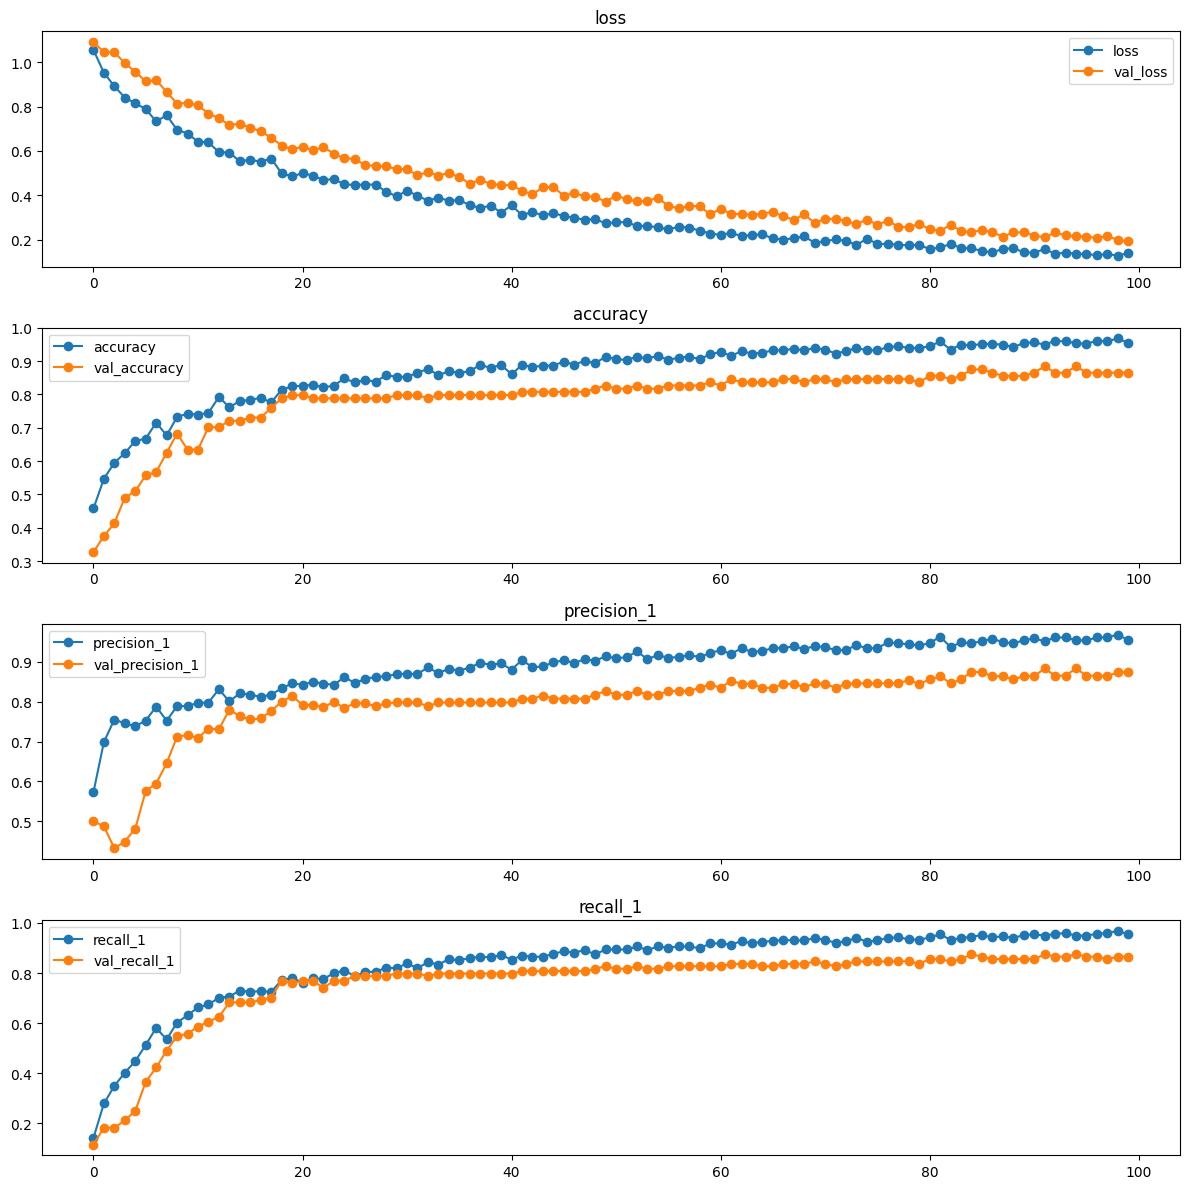

In [40]:
# @title Model v1
# define model function
def build_model():
  # instantiate the model
  model = Sequential()

  # define the 1st hidden layer
  model.add(Dense(29, input_dim=input_dim, activation='relu'))
  model.add(Dense(29, activation = 'relu'))
  model.add(Dropout(.2))
  #Output layer
  model.add(Dense(output_dim, activation = 'softmax'))

  # compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  return model

# build model
model_v1 = build_model()

# Get model summary
model_v1.summary()

# fit and obtain history
history = model_v1.fit(X_train_tf_sm, y_train_bin,
                          validation_split = .2,
                          epochs=100,
                          verbose=0)

# plot history
plot_history(history, figsize=(12, 12));

4/4 [==============================] - 0s 5ms/step
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.76      0.75        59
           1       0.00      0.00      0.00         7
           2       0.68      0.69      0.68        39

    accuracy                           0.69       105
   macro avg       0.47      0.49      0.48       105
weighted avg       0.67      0.69      0.68       105



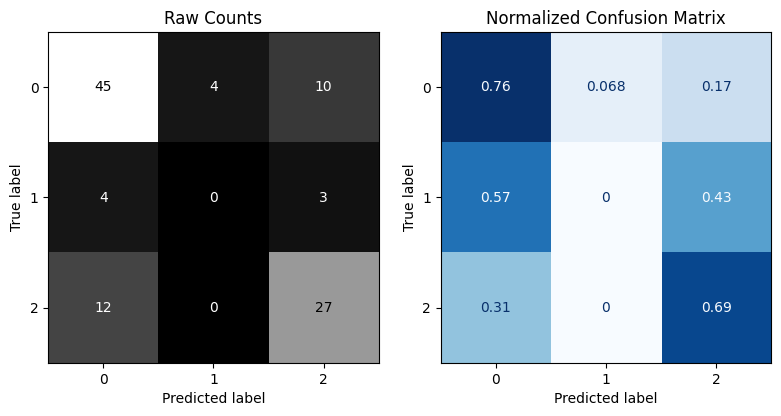

In [41]:
# get raw predictions
raw_pred = model_v1.predict(X_test_tf)

# convert predictions and labels into integers representing each status class.
y_pred = np.argmax(raw_pred, axis=1)
y_true = np.argmax(y_test_bin, axis=1)

# evaluate our model v1
classification_metrics(y_true, y_pred, label='Test Data')

In [42]:
# @title Tune to Obtain Best Model - v2
# Define the HyperModel class to obtain model v2
class TuneHyperModel(HyperModel):
    def build(self, hp):
        # Instantiate the model
        model = Sequential()

        # Input layer
        model.add(Dense(
            units=hp.Int('units_1', min_value=29, max_value=203, step=29),
            activation='relu',
            input_dim=input_dim
        ))

        # Hidden layers
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Dense(
                units=hp.Int(f'units_{i+2}', min_value=29, max_value=203, step=29),
                activation='relu'
            ))
            model.add(Dropout(rate=hp.Float(f'dropout_{i+1}', min_value=0.0, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(output_dim, activation='softmax'))

        # Compile the model
        model.compile(optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),
                  loss='bce',
                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision')])
        return model

In [43]:
# Initialize the Hyperband tuner
tuner = kt.Hyperband(
    TuneHyperModel(),
    objective='val_accuracy',
    max_epochs=50,
    overwrite = True,
    seed = 42,
    directory='/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week19/Data',
    project_name='CirrhosisPrediction'
)

# Display a summary of the search space
tuner.search_space_summary()

# Perform the hyperparameter search
early_stop = EarlyStopping(monitor='val_loss', patience=10)
tuner.search(X_train_tf_sm, y_train_bin, epochs=50, validation_split=0.2, callbacks=[early_stop])

Trial 90 Complete [00h 00m 12s]
val_accuracy: 0.9711538553237915

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 07m 47s


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 203)               6090      
                                                                 
 dense_6 (Dense)             (None, 87)                17748     
                                                                 
 dropout_3 (Dropout)         (None, 87)                0         
                                                                 
 dense_7 (Dense)             (None, 174)               15312     
                                                                 
 dropout_4 (Dropout)         (None, 174)               0         
                                                                 
 dense_8 (Dense)             (None, 3)                 525       
                                                                 
Total params: 39675 (154.98 KB)
Trainable params: 3967

None

Epoch 1/100
13/13 [==============================] - 2s 37ms/step - loss: 0.6029 - accuracy: 0.5639 - recall: 0.1422 - precision: 0.7867 - val_loss: 0.6074 - val_accuracy: 0.4038 - val_recall: 0.2212 - val_precision: 0.4035
Epoch 2/100
13/13 [==============================] - 0s 12ms/step - loss: 0.4730 - accuracy: 0.7012 - recall: 0.6000 - precision: 0.7568 - val_loss: 0.5025 - val_accuracy: 0.6346 - val_recall: 0.6154 - val_precision: 0.6809
Epoch 3/100
13/13 [==============================] - 0s 11ms/step - loss: 0.3833 - accuracy: 0.7590 - recall: 0.7229 - precision: 0.7853 - val_loss: 0.4586 - val_accuracy: 0.6250 - val_recall: 0.6250 - val_precision: 0.6436
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: 0.3415 - accuracy: 0.7880 - recall: 0.7711 - precision: 0.8081 - val_loss: 0.4392 - val_accuracy: 0.7115 - val_recall: 0.7019 - val_precision: 0.7157
Epoch 5/100
13/13 [==============================] - 0s 10ms/step - loss: 0.3169 - accuracy: 0.8096 - re

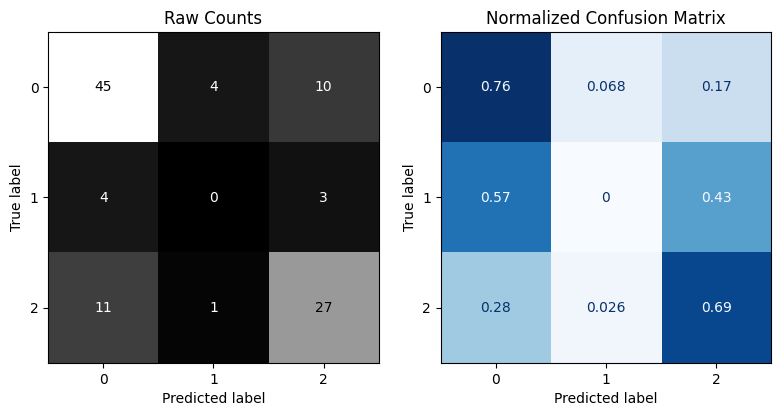

In [44]:
# Get the best hyperparameters
best_hype = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display best hyperparameters
display(best_hype)

# Build the best model
model_v2 = tuner.hypermodel.build(best_hype)

# Display the best model
display(model_v2.summary())

# Train the best model
history_v2 = model_v2.fit(X_train_tf_sm, y_train_bin, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop])

# Evaluate the best model
## predict the y - label
y_pred_v2 = model_v2.predict(X_test_tf)
## convert to integer
y_pred_v2 = np.argmax(y_pred_v2, axis=1)
y_true_v2 = np.argmax(y_test_bin, axis=1)
## evaluate
classification_metrics(y_true_v2, y_pred_v2, label='Test Data')

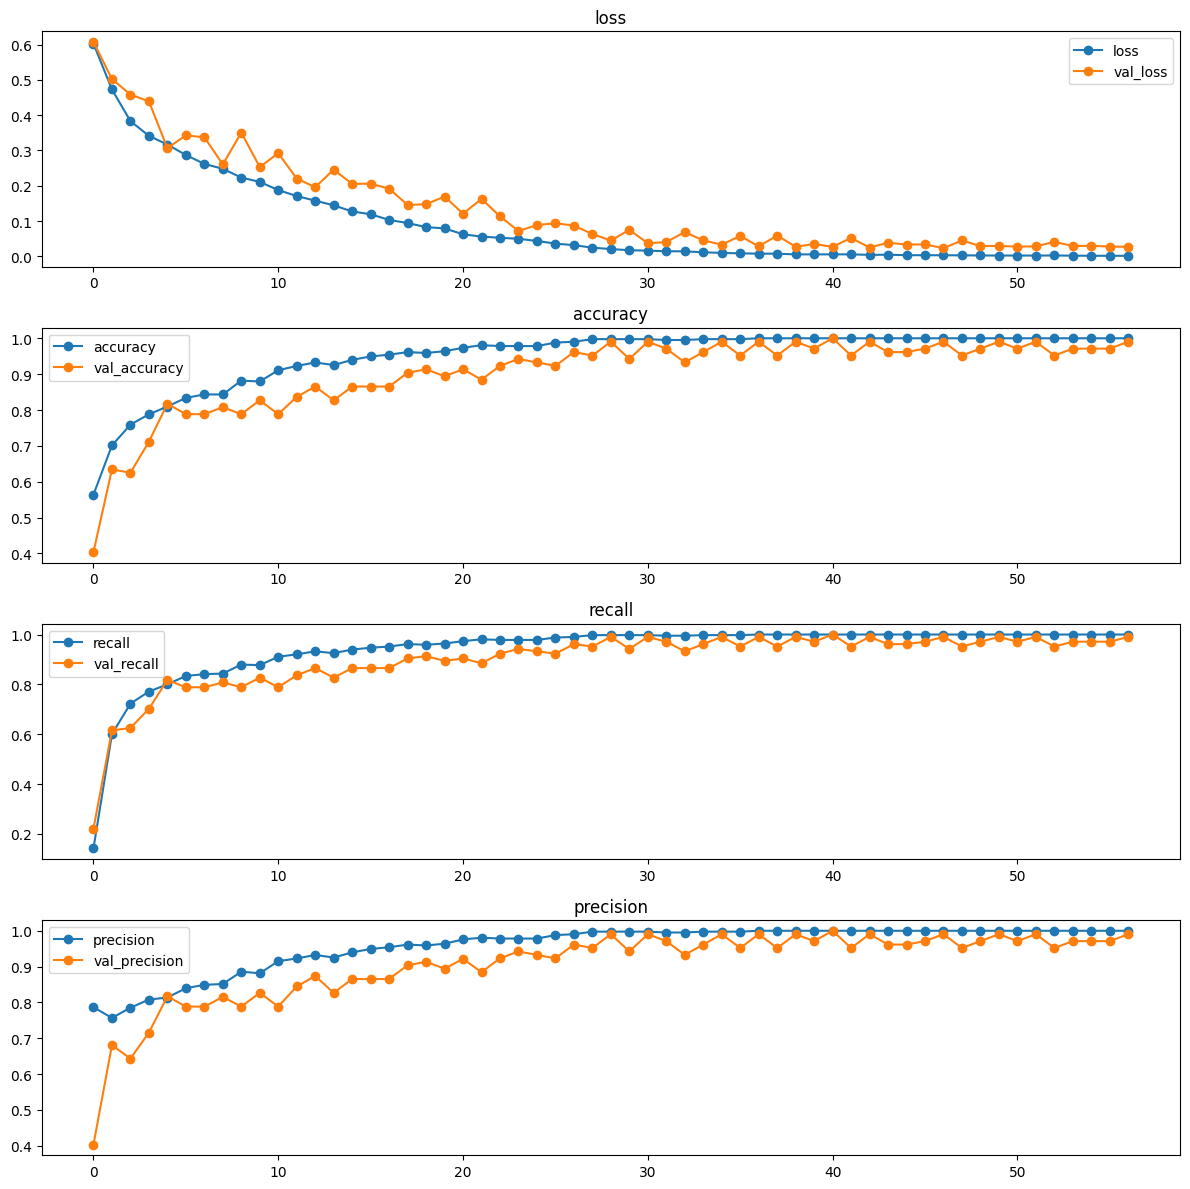

In [45]:
# Visualize the model history v4
plot_history(history_v2, figsize=(12,12));

We see improvement in reduction of overfit though accuracy remained the same